In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
from shapely.geometry import Point
import matplotlib.pyplot as plt
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.plot import plotting_extent
from natsort import natsorted
import gdal
import pandas as pd
import numpy as np
import geopandas
import rasterio
import pycrs

file_dir=r'C:/Users/Mark.Rademaker/PycharmProjects/InternshipNaturalis/venv/github_trait_geo_diverse_dl/trait-geo-diverse-dl'

In [10]:
#access file with list of taxa names
taxa=pd.read_csv(file_dir+"/data/SQL_filtered_gbif/taxa_list.txt",header=None)
taxa.columns=["taxon"]

species_occ_dict={}

for i in taxa["taxon"]:
    taxon_data = pd.read_csv(file_dir+"/data/SQL_filtered_gbif/%s_filtered_data.csv"%i)
    #add species dataframe to dict
    species_occ_dict["%s"%i] = taxon_data  
    #check whether all species have been included and inspect dictionary
if len(species_occ_dict.keys())==len(taxa["taxon"]):
    print("All species dataframes now in dictionary")
else:
    print("Error: not all species dataframe included")

All species dataframes now in dictionary


#### Part 1
- First read in occurrence data
- Create a copy that we can use in the original state later
- Create a buffer around each occurrence point, merge it into a single polygon
- Clip the environmental raster based on this extend

In [ ]:
for key in species_occ_dict:    
    #load occurrence data and set initial projection
    data=species_occ_dict[key]
    print(data.columns)
    spec = key


    data['coordinates'] = list(zip(data["decimal_longitude"], data["decimal_latitude"]))
    data['coordinates'] = data["coordinates"].apply(Point)
    data["present/pseudo_absent"]=1
    geo_data=geopandas.GeoDataFrame(data, geometry='coordinates',crs={'init' :'epsg:4326'})

    #change projection to azimuthal equidistant to calculate 1000km buffer around point
    geo_data = geo_data.to_crs({'init': 'esri:54032'}) 
    buffer=geo_data.buffer(1000*1000)
    buffer=buffer.to_crs(epsg=4326)

    #create single large polygon from individual buffers
    union_buffer=buffer.unary_union

    #first clip the raster based on this extend 
    raster=rasterio.open(file_dir+'/data/GIS/env_stacked/ENVIREM_BIOCLIM_stacked.tif')
    #specify output tif:
    out_tif = file_dir+'/data/GIS/spec_stacked_raster_clip/%s_raster_clip.tif'%spec

    #clip the raster:
    out_img, out_transform = mask(dataset=raster, shapes=[union_buffer],crop=True)
   
    # Copy the metadata
    out_meta = raster.meta.copy()

    # Parse EPSG code
    epsg_code = int(raster.crs.data['init'][5:])
    out_meta.update({"driver": "GTiff",
                     "height": out_img.shape[1],
                     "width": out_img.shape[2],
                     "transform": out_transform,
                     "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()})

    with rasterio.open(out_tif, "w", **out_meta) as dest:
            dest.write(out_img)

Inspect whether clip was correct

In [ ]:
#Inspect the first band of the clipped raster for all species
for key in species_occ_dict:
    ##### Extract occurrence point to plot on the raster (see if correct area was clipped)
    data=species_occ_dict[key]
    spec = key
    data['coordinates'] = list(zip(data["decimal_longitude"], data["decimal_latitude"]))
    data['coordinates'] = data["coordinates"].apply(Point)
    geo_data=geopandas.GeoDataFrame(data, geometry='coordinates',crs={'init' :'epsg:4326'})
    ####open the clipped raster
    clipped = rasterio.open(file_dir+'/data/GIS/spec_stacked_raster_clip/%s_raster_clip.tif'%spec)
    array = clipped.read(1)
    array_data = clipped.read(1,masked=True)
    array_meta = clipped.profile
   
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(array_data,cmap="gist_earth",interpolation="none",vmin=0,
    # Here you must set the spatial extent or else the data will not line up with your geopandas layer
    extent=plotting_extent(clipped),)
    spec_plots_points=geo_data["coordinates"]
    spec_plots_points.plot(ax=ax,
                       marker='o',
                       markersize=20,
                       color='red')
    ax.set_title("%s \n Raster clip and occurrence points"%spec,
             fontsize=20)
    plt.show()
#Works!

#### Part 2
- now that we have the clipped raster we can use it to try and make a random selection of pseudo absence points
- we first open the raster
- then we separate those cells that actually contain pixel values (excluding the sea)
- we calculate the longitude and latitude of the centre point of these cells <br>
  (the environmental variable values do not vary within each cell so it doesn't matter if each points is in the centre)
- we make a random selection of 10.0000 positions
- we add the longitude and latitude values of these to to the dataset and export it  

Text(0.5, 1.0, 'Aepyceros_melampus')

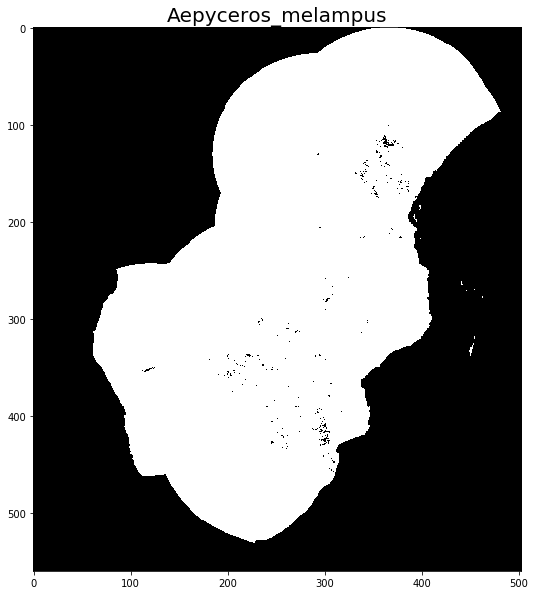

966 number of pseudo absences
1932 lenght data with pseudo absences


C:\Users\Mark.Rademaker\PycharmProjects\InternshipNaturalis\venv\lib\site-packages\ipykernel_launcher.py:55: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Text(0.5, 1.0, 'Alcelaphus_buselaphus')

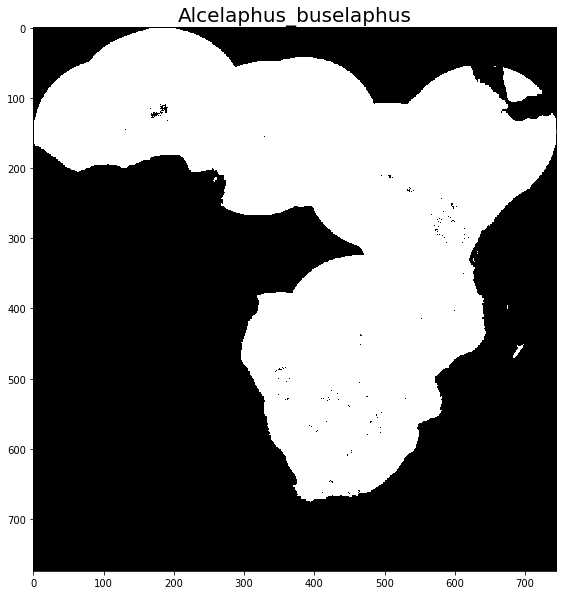

863 number of pseudo absences
1726 lenght data with pseudo absences


Text(0.5, 1.0, 'Alces_alces')

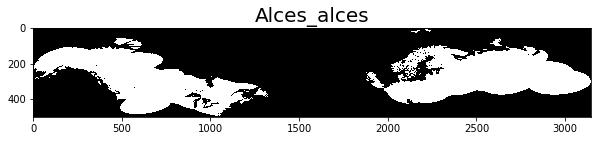

10480 number of pseudo absences
20960 lenght data with pseudo absences


Text(0.5, 1.0, 'Antidorcas_marsupialis')

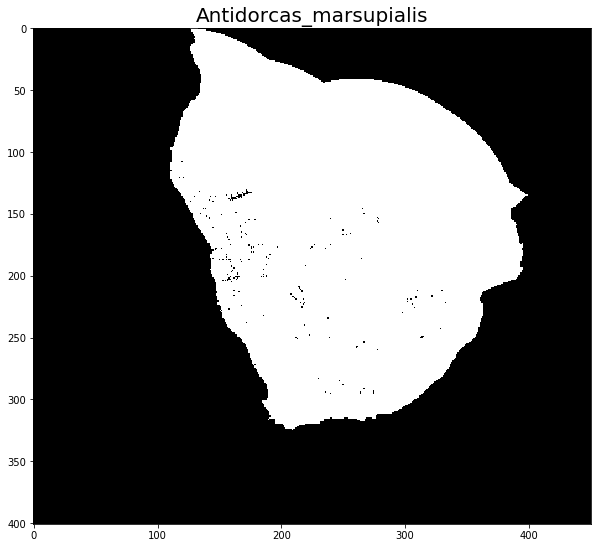

330 number of pseudo absences
660 lenght data with pseudo absences


Text(0.5, 1.0, 'Antilocapra_americana')

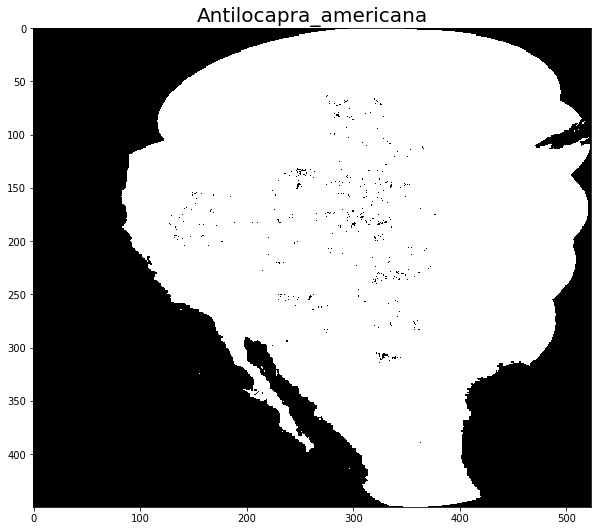

794 number of pseudo absences
1588 lenght data with pseudo absences


Text(0.5, 1.0, 'Antilope_cervicapra')

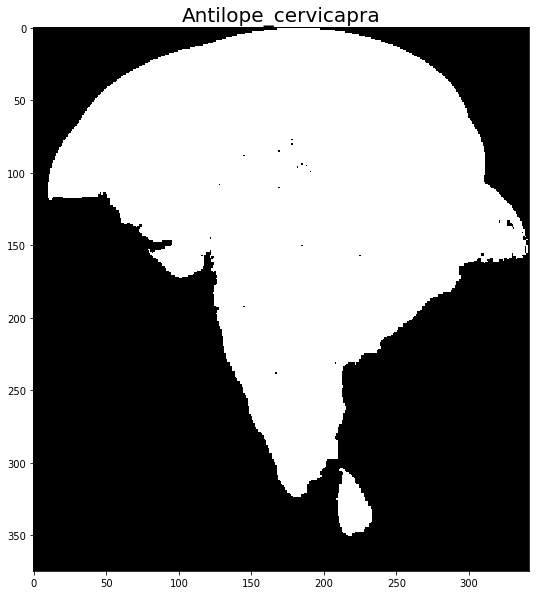

22 number of pseudo absences
44 lenght data with pseudo absences


Text(0.5, 1.0, 'Axis_axis')

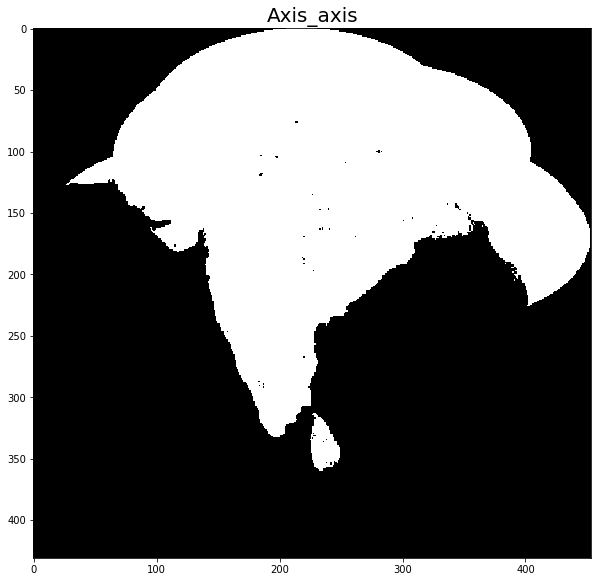

88 number of pseudo absences
176 lenght data with pseudo absences


Text(0.5, 1.0, 'Axis_porcinus')

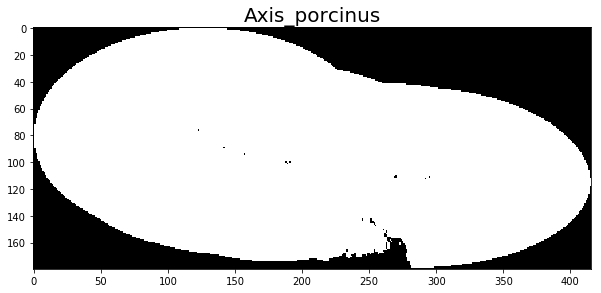

12 number of pseudo absences
24 lenght data with pseudo absences


Text(0.5, 1.0, 'Bison_bison')

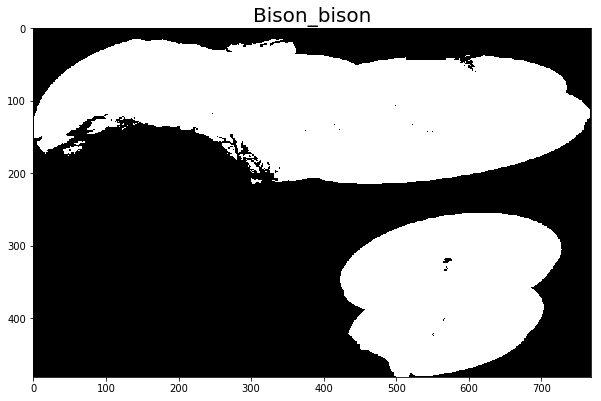

431 number of pseudo absences
862 lenght data with pseudo absences


Text(0.5, 1.0, 'Bison_bonasus')

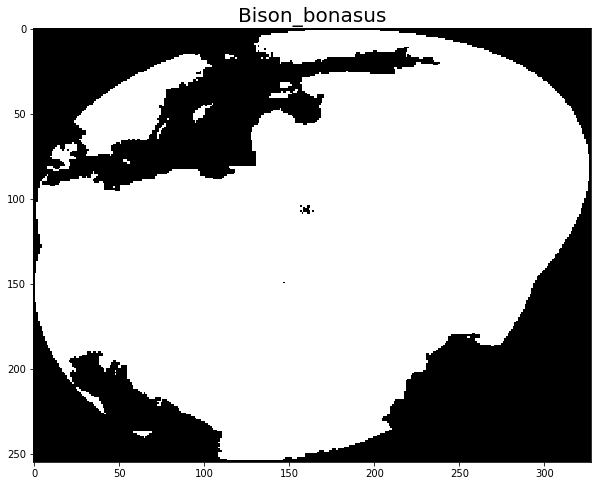

29 number of pseudo absences
58 lenght data with pseudo absences


Text(0.5, 1.0, 'Blastocerus_dichotomus')

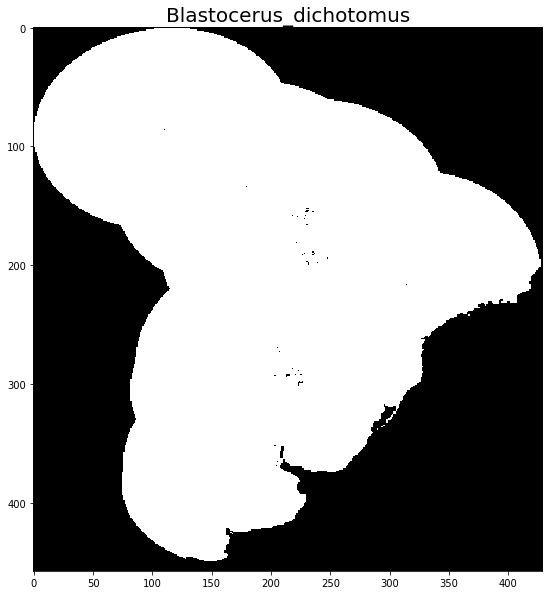

166 number of pseudo absences
332 lenght data with pseudo absences


Text(0.5, 1.0, 'Bos_javanicus')

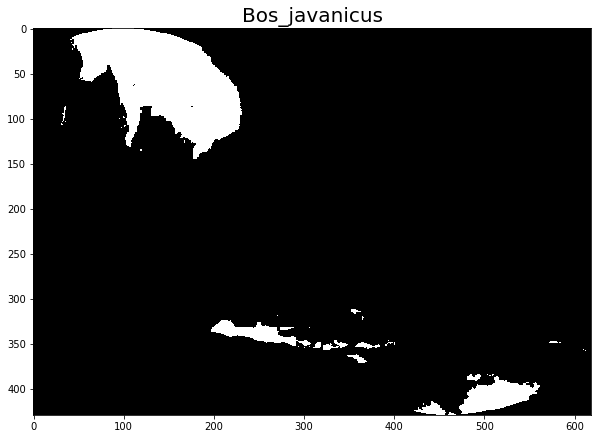

87 number of pseudo absences
174 lenght data with pseudo absences


Text(0.5, 1.0, 'Boselaphus_tragocamelus')

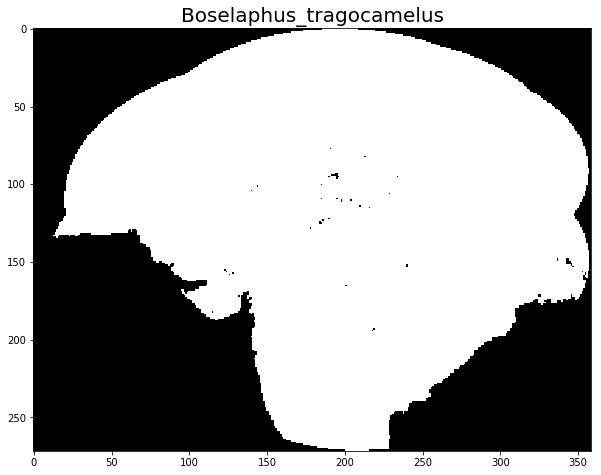

54 number of pseudo absences
108 lenght data with pseudo absences


Text(0.5, 1.0, 'Capra_ibex')

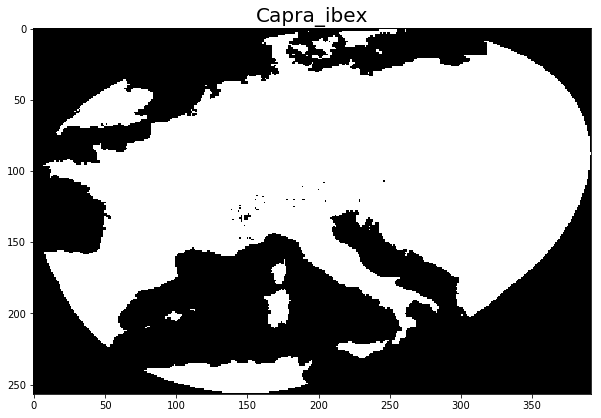

91 number of pseudo absences
182 lenght data with pseudo absences


Text(0.5, 1.0, 'Capra_nubiana')

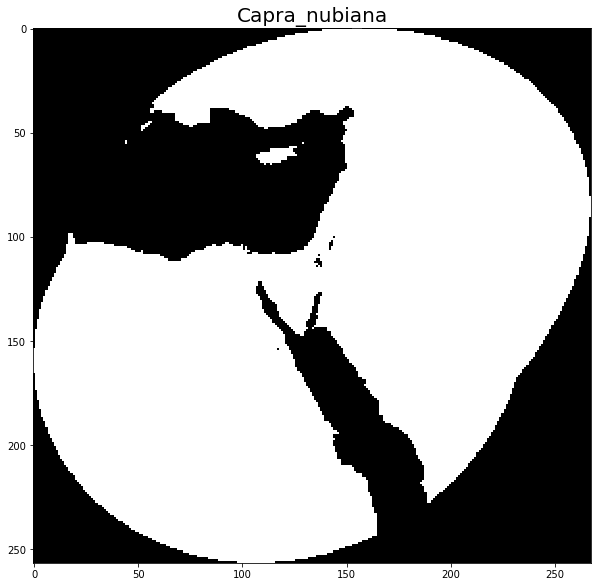

31 number of pseudo absences
62 lenght data with pseudo absences


Text(0.5, 1.0, 'Capra_pyrenaica')

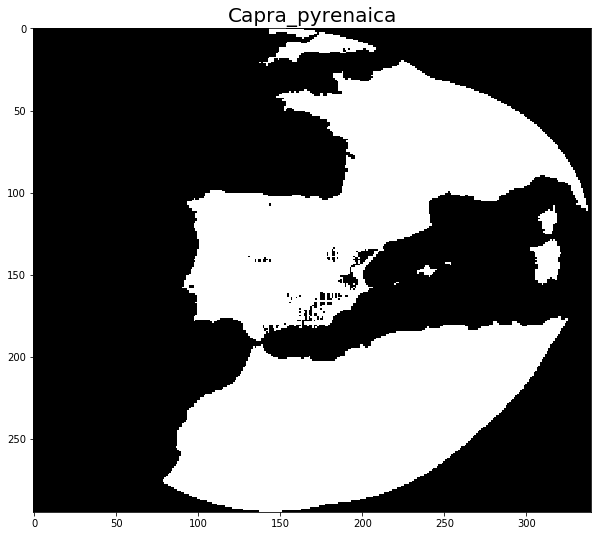

704 number of pseudo absences
1408 lenght data with pseudo absences


Text(0.5, 1.0, 'Capra_sibirica')

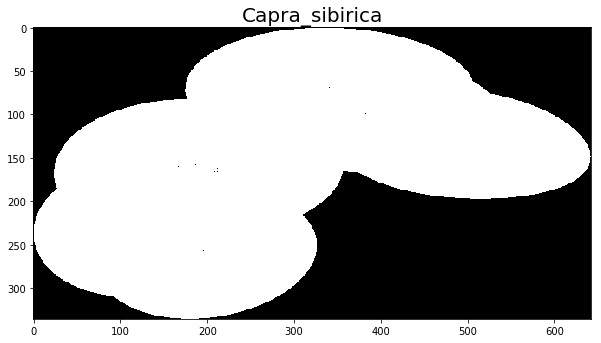

12 number of pseudo absences
24 lenght data with pseudo absences


Text(0.5, 1.0, 'Capreolus_capreolus')

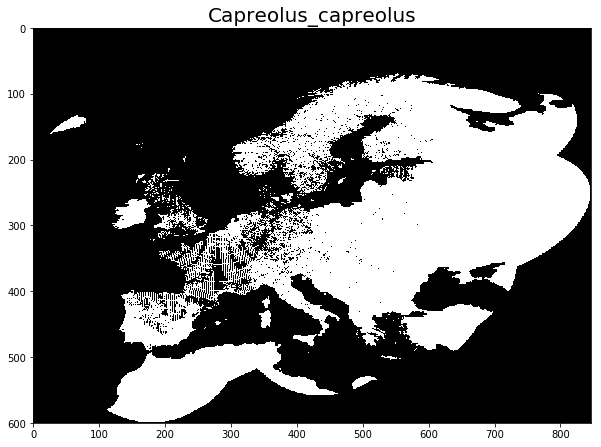

58329 number of pseudo absences
116658 lenght data with pseudo absences


Text(0.5, 1.0, 'Capreolus_pygargus')

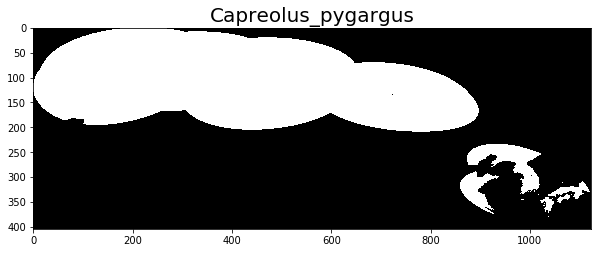

20 number of pseudo absences
40 lenght data with pseudo absences


Text(0.5, 1.0, 'Capricornis_crispus')

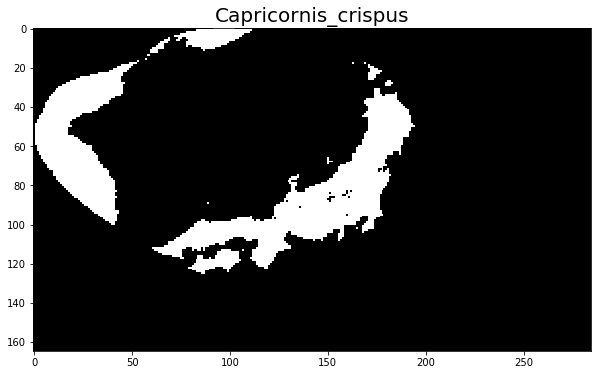

47 number of pseudo absences
94 lenght data with pseudo absences


Text(0.5, 1.0, 'Capricornis_swinhoei')

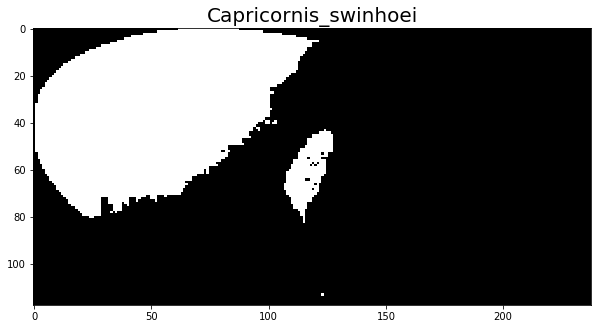

21 number of pseudo absences
42 lenght data with pseudo absences


Text(0.5, 1.0, 'Catagonus_wagneri')

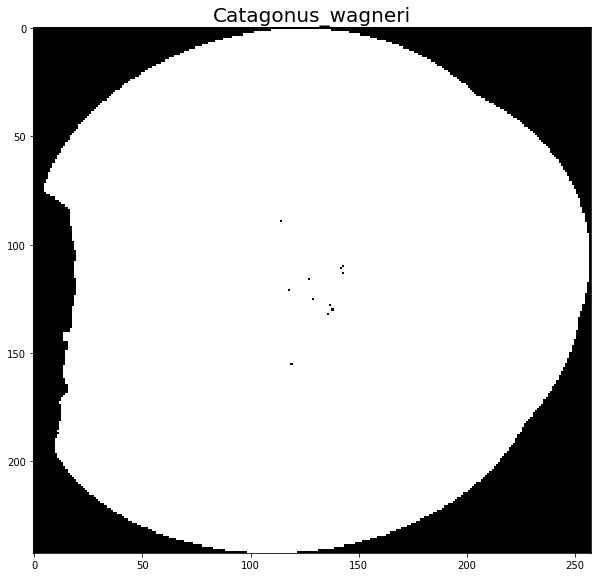

11 number of pseudo absences
22 lenght data with pseudo absences


Text(0.5, 1.0, 'Cephalophus_dorsalis')

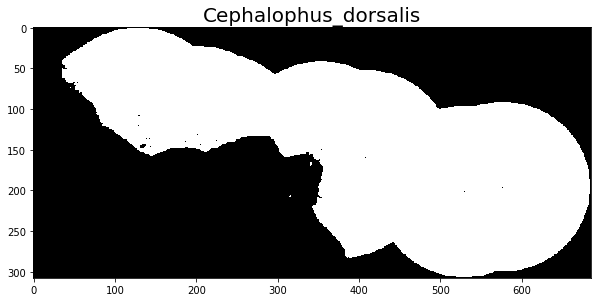

264 number of pseudo absences
528 lenght data with pseudo absences


Text(0.5, 1.0, 'Cephalophus_jentinki')

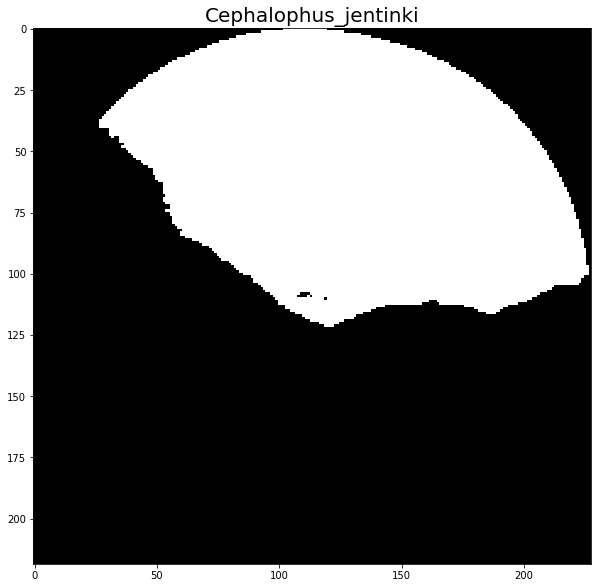

36 number of pseudo absences
72 lenght data with pseudo absences


Text(0.5, 1.0, 'Cephalophus_natalensis')

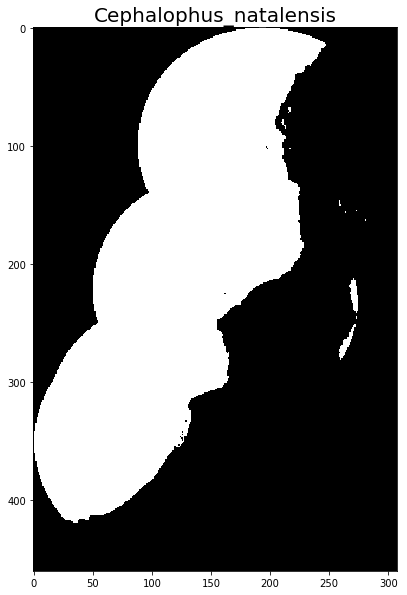

47 number of pseudo absences
94 lenght data with pseudo absences


Text(0.5, 1.0, 'Cephalophus_niger')

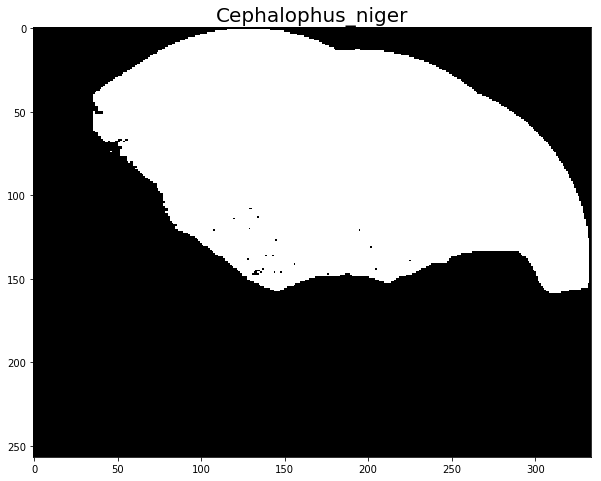

38 number of pseudo absences
76 lenght data with pseudo absences


Text(0.5, 1.0, 'Cephalophus_nigrifrons')

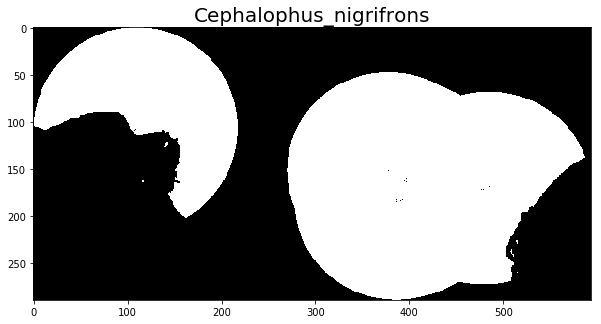

19 number of pseudo absences
38 lenght data with pseudo absences


Text(0.5, 1.0, 'Cephalophus_rufilatus')

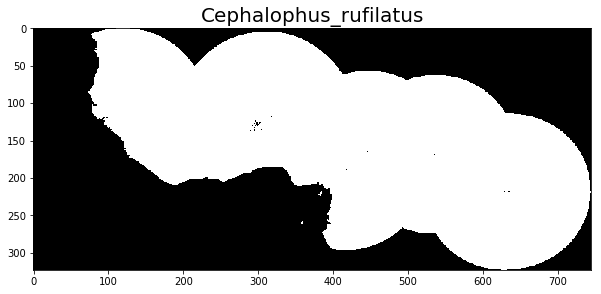

170 number of pseudo absences
340 lenght data with pseudo absences


Text(0.5, 1.0, 'Cephalophus_silvicultor')

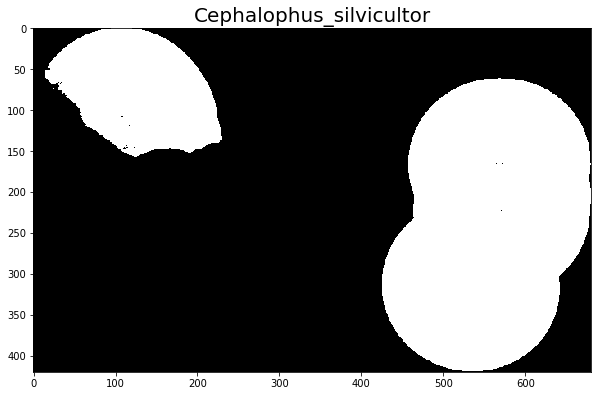

29 number of pseudo absences
58 lenght data with pseudo absences


Text(0.5, 1.0, 'Cephalophus_zebra')

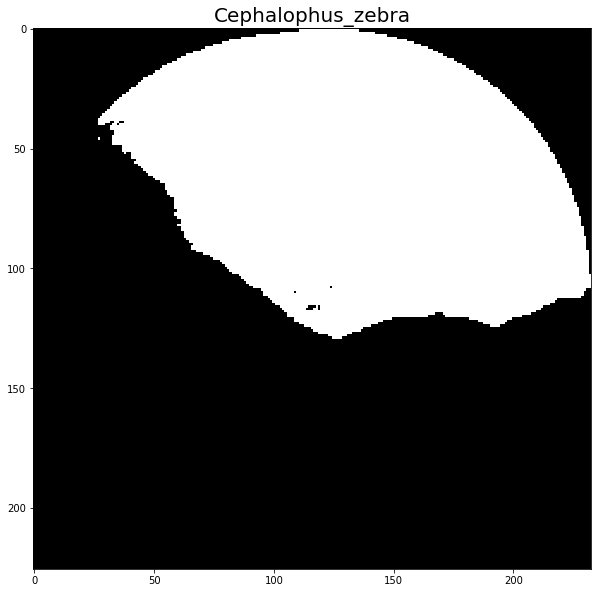

46 number of pseudo absences
92 lenght data with pseudo absences


Text(0.5, 1.0, 'Ceratotherium_simum')

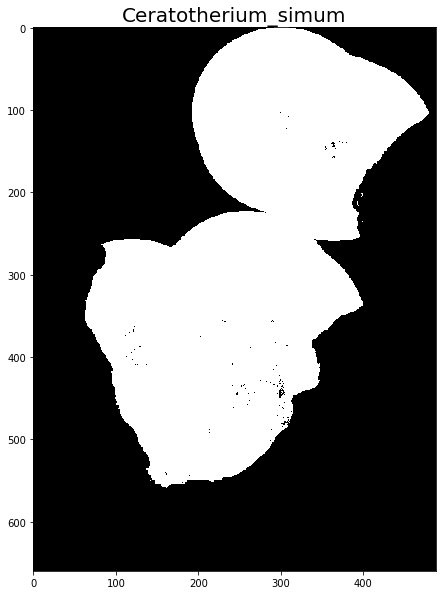

423 number of pseudo absences
846 lenght data with pseudo absences


Text(0.5, 1.0, 'Cervus_elaphus')

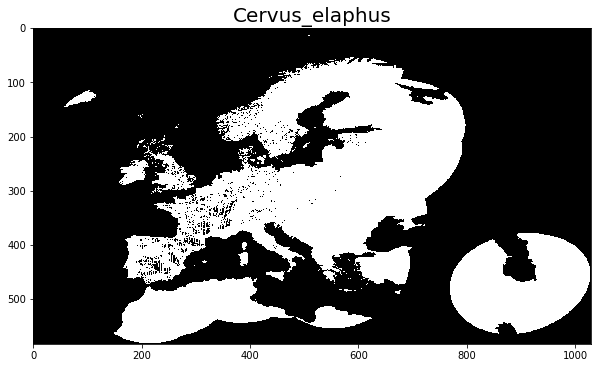

16203 number of pseudo absences
32406 lenght data with pseudo absences


Text(0.5, 1.0, 'Cervus_nippon')

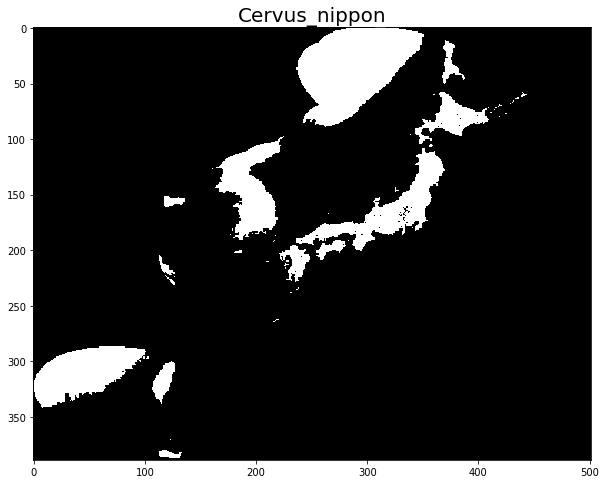

95 number of pseudo absences
190 lenght data with pseudo absences


Text(0.5, 1.0, 'Connochaetes_gnou')

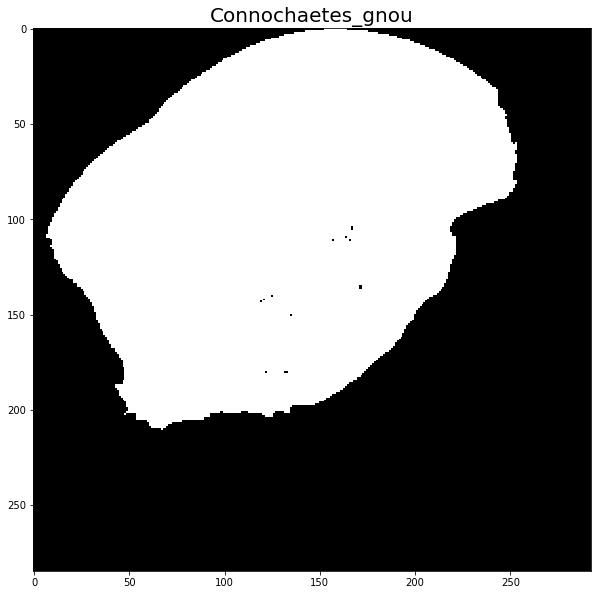

40 number of pseudo absences
80 lenght data with pseudo absences


Text(0.5, 1.0, 'Connochaetes_taurinus')

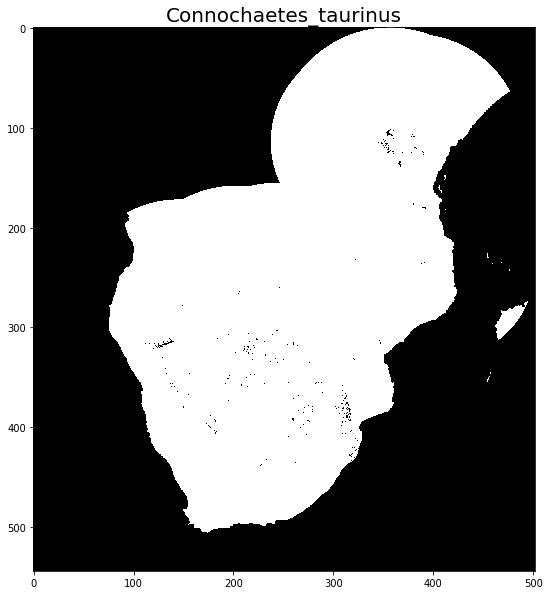

503 number of pseudo absences
1006 lenght data with pseudo absences


Text(0.5, 1.0, 'Dama_dama')

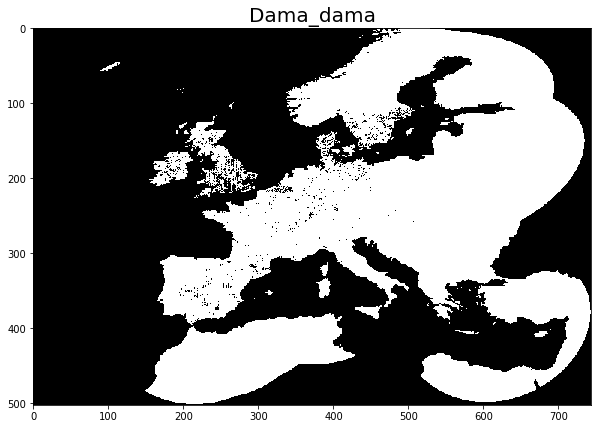

7326 number of pseudo absences
14652 lenght data with pseudo absences


Text(0.5, 1.0, 'Damaliscus_lunatus')

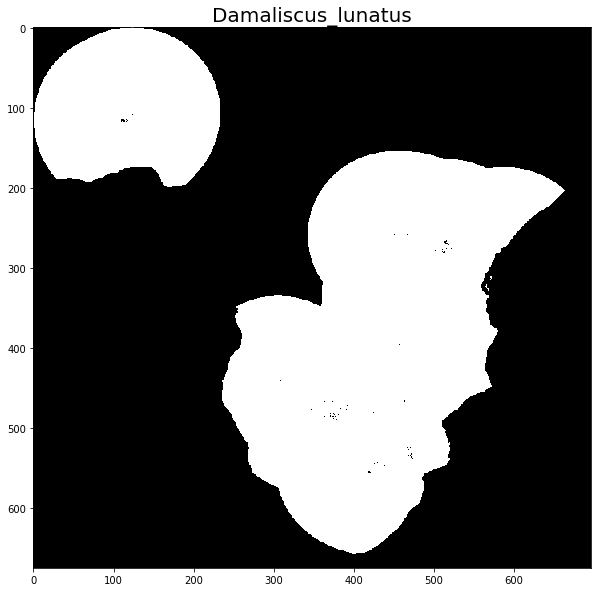

175 number of pseudo absences
350 lenght data with pseudo absences


Text(0.5, 1.0, 'Damaliscus_pygargus')

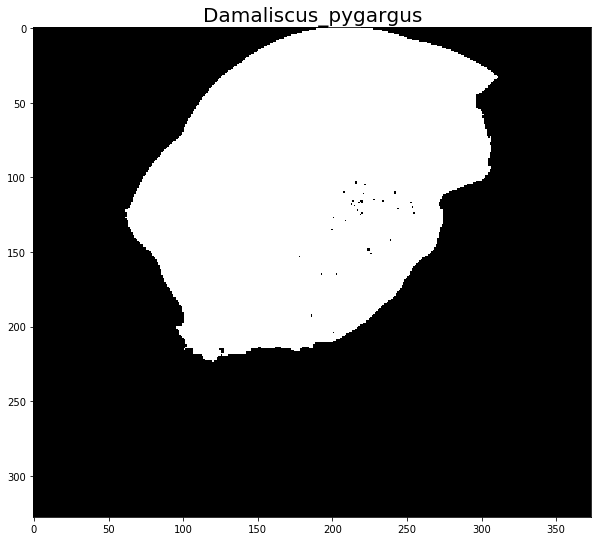

99 number of pseudo absences
198 lenght data with pseudo absences


Text(0.5, 1.0, 'Diceros_bicornis')

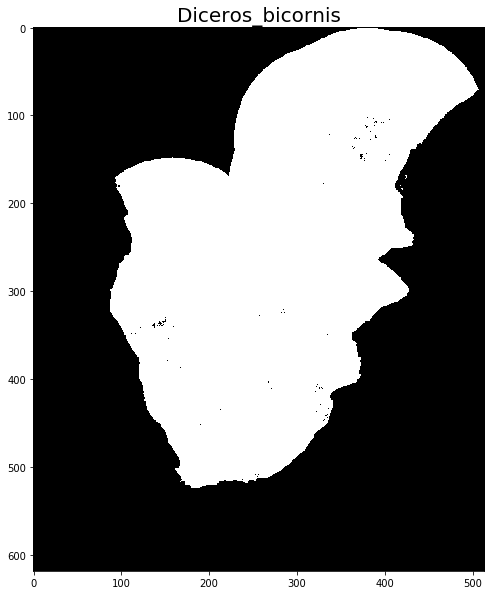

180 number of pseudo absences
360 lenght data with pseudo absences


Text(0.5, 1.0, 'Equus_grevyi')

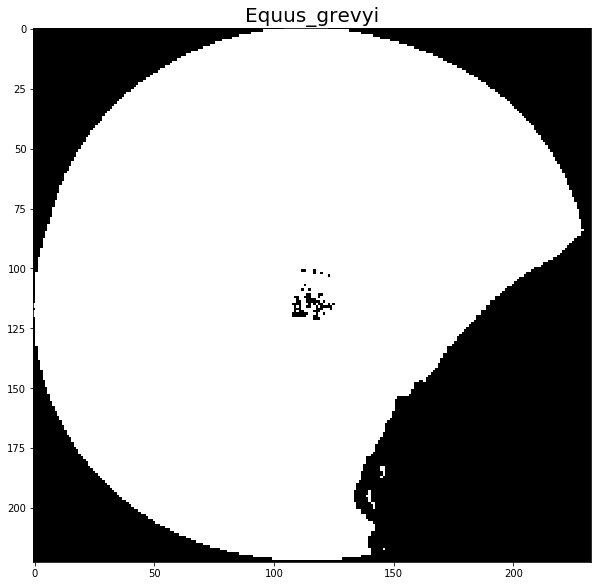

272 number of pseudo absences
544 lenght data with pseudo absences


Text(0.5, 1.0, 'Equus_hemionus')

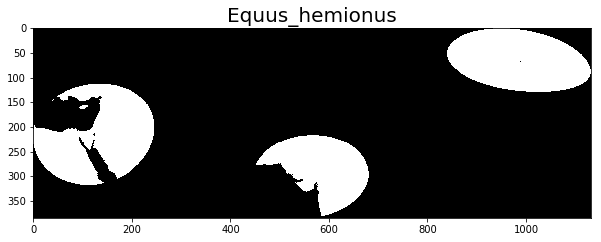

57 number of pseudo absences
114 lenght data with pseudo absences


Text(0.5, 1.0, 'Equus_kiang')

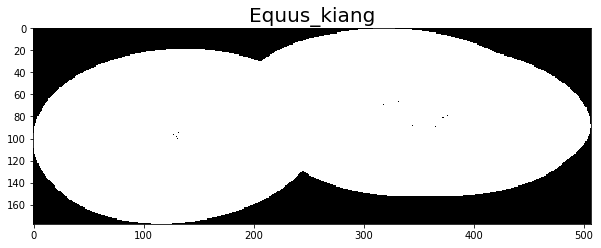

10 number of pseudo absences
20 lenght data with pseudo absences


Text(0.5, 1.0, 'Equus_quagga')

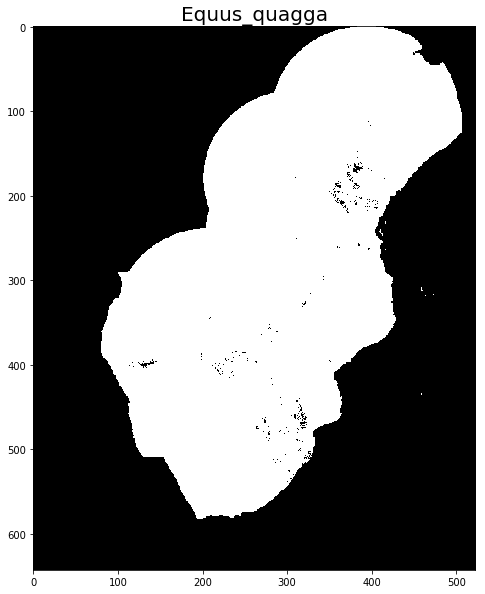

1406 number of pseudo absences
2812 lenght data with pseudo absences


Text(0.5, 1.0, 'Equus_zebra')

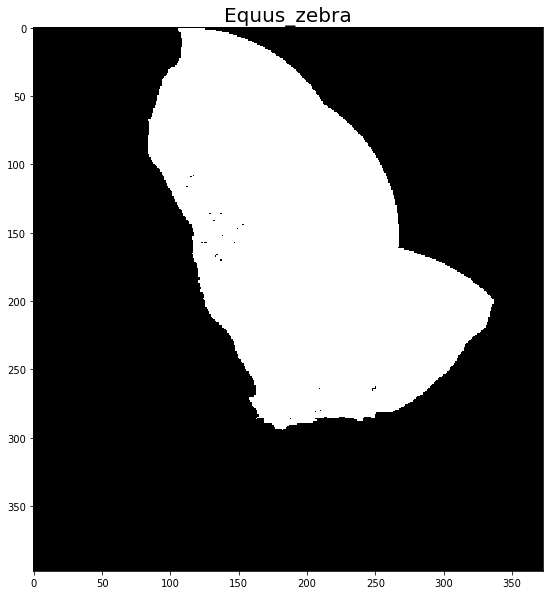

44 number of pseudo absences
88 lenght data with pseudo absences


Text(0.5, 1.0, 'Eudorcas_rufifrons')

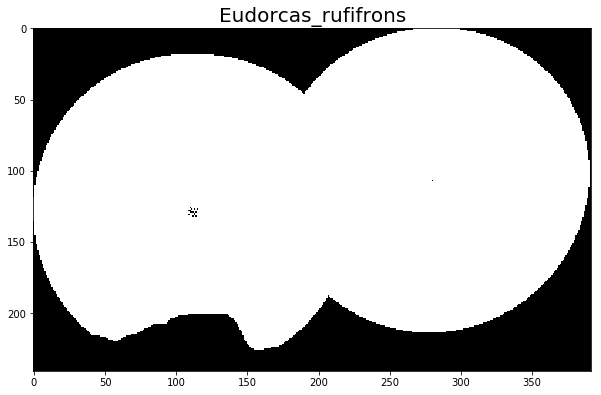

17 number of pseudo absences
34 lenght data with pseudo absences


Text(0.5, 1.0, 'Eudorcas_thomsonii')

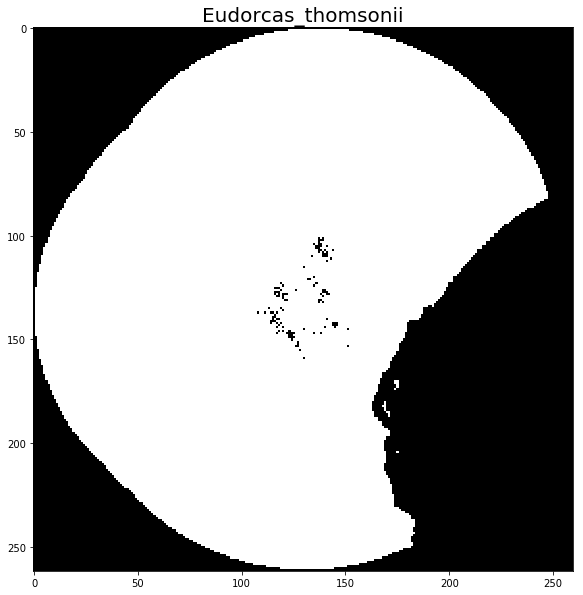

185 number of pseudo absences
370 lenght data with pseudo absences


Text(0.5, 1.0, 'Gazella_bennettii')

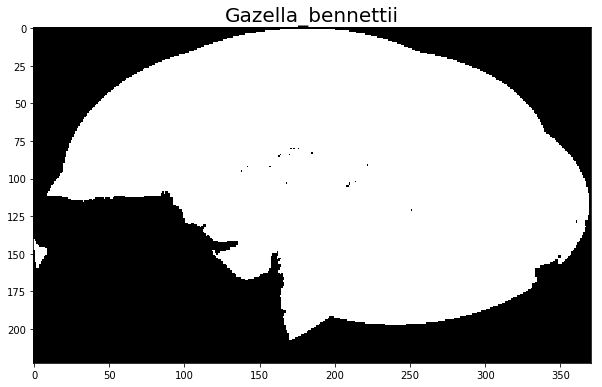

23 number of pseudo absences
46 lenght data with pseudo absences


Text(0.5, 1.0, 'Gazella_dorcas')

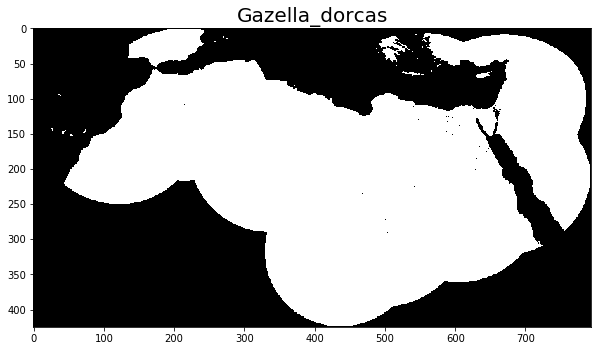

689 number of pseudo absences
1378 lenght data with pseudo absences


Text(0.5, 1.0, 'Gazella_gazella')

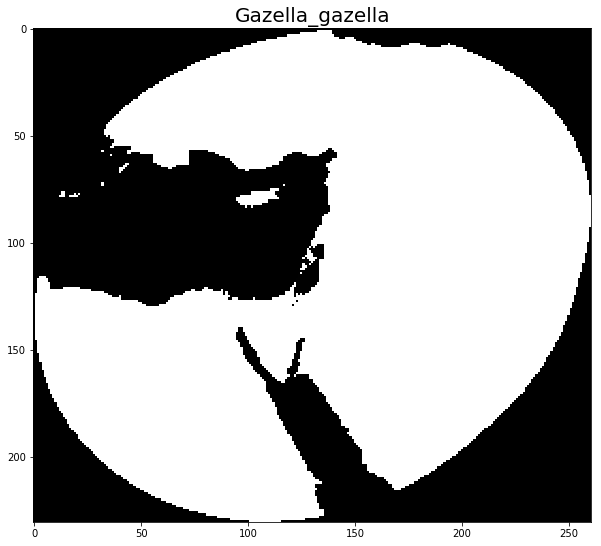

3496 number of pseudo absences
6992 lenght data with pseudo absences


Text(0.5, 1.0, 'Gazella_subgutturosa')

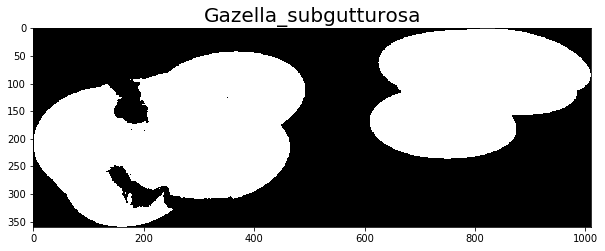

17 number of pseudo absences
34 lenght data with pseudo absences


Text(0.5, 1.0, 'Giraffa_camelopardalis')

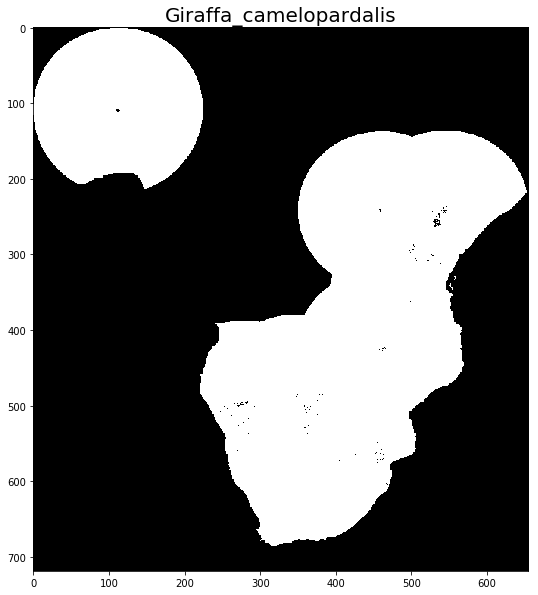

440 number of pseudo absences
880 lenght data with pseudo absences


Text(0.5, 1.0, 'Hippopotamus_amphibius')

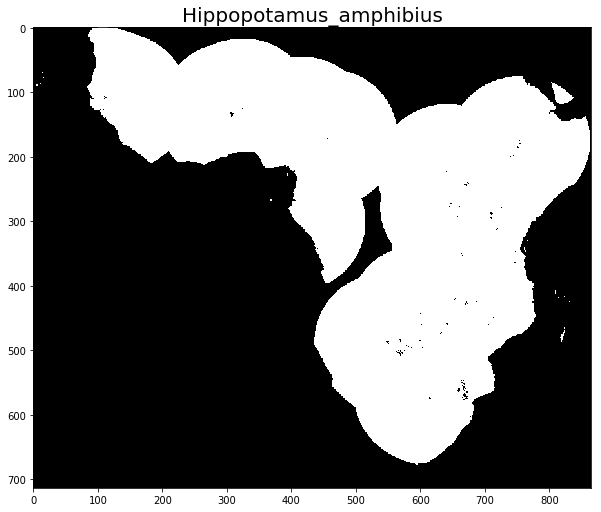

530 number of pseudo absences
1060 lenght data with pseudo absences


Text(0.5, 1.0, 'Hippotragus_equinus')

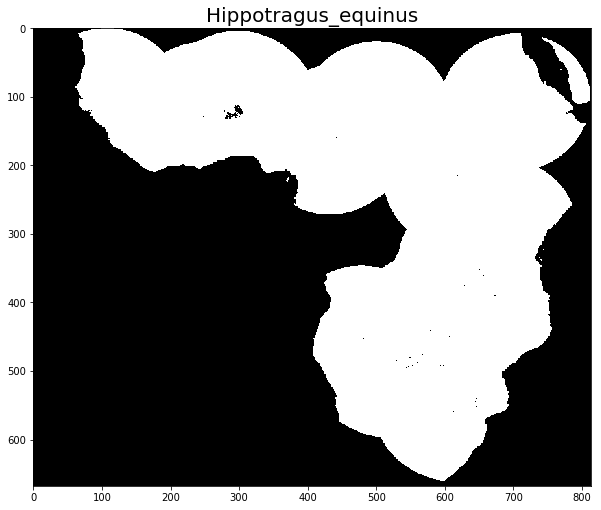

1555 number of pseudo absences
3110 lenght data with pseudo absences


Text(0.5, 1.0, 'Hippotragus_niger')

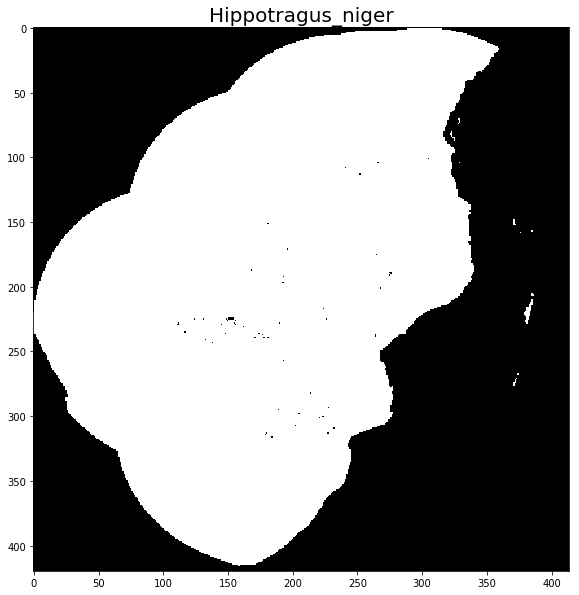

74 number of pseudo absences
148 lenght data with pseudo absences


Text(0.5, 1.0, 'Hydropotes_inermis')

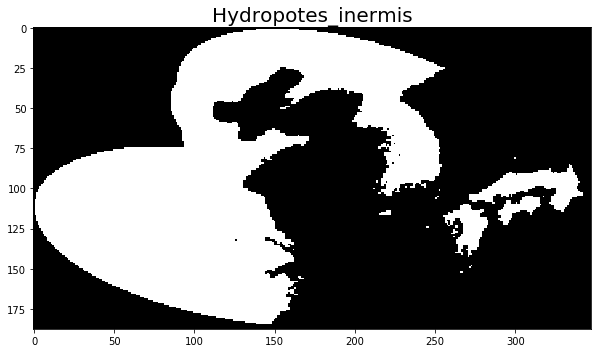

39 number of pseudo absences
78 lenght data with pseudo absences


Text(0.5, 1.0, 'Hyemoschus_aquaticus')

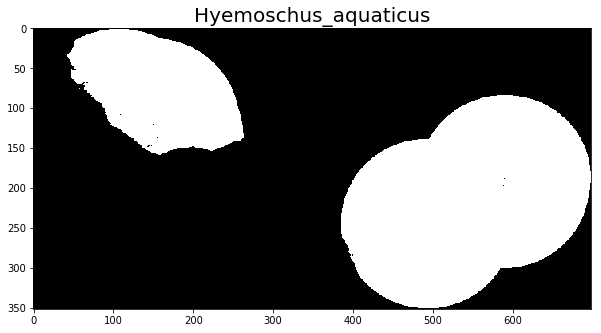

34 number of pseudo absences
68 lenght data with pseudo absences


Text(0.5, 1.0, 'Hylochoerus_meinertzhageni')

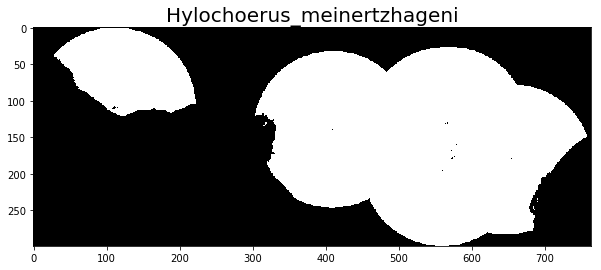

38 number of pseudo absences
76 lenght data with pseudo absences


Text(0.5, 1.0, 'Kobus_ellipsiprymnus')

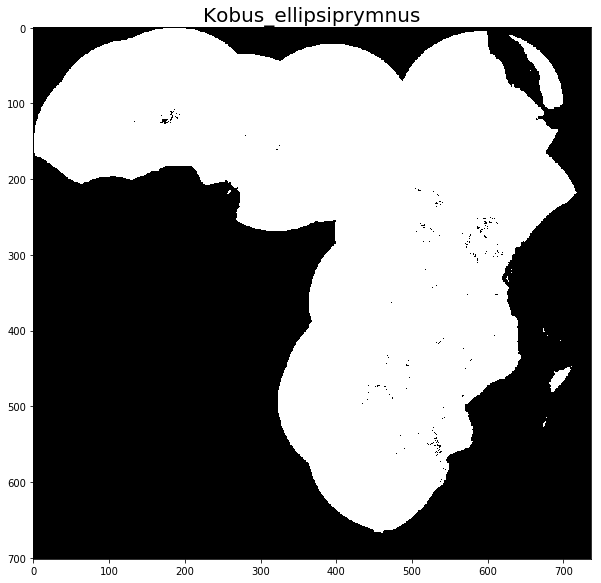

846 number of pseudo absences
1692 lenght data with pseudo absences


Text(0.5, 1.0, 'Kobus_kob')

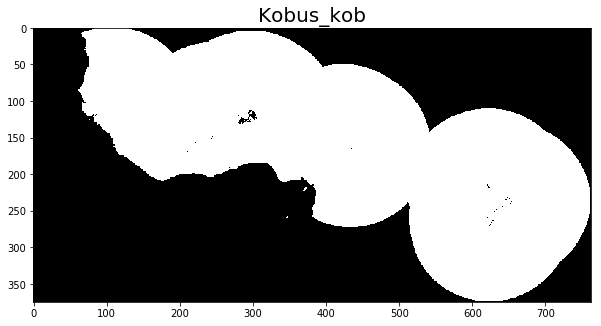

2494 number of pseudo absences
4988 lenght data with pseudo absences


Text(0.5, 1.0, 'Kobus_leche')

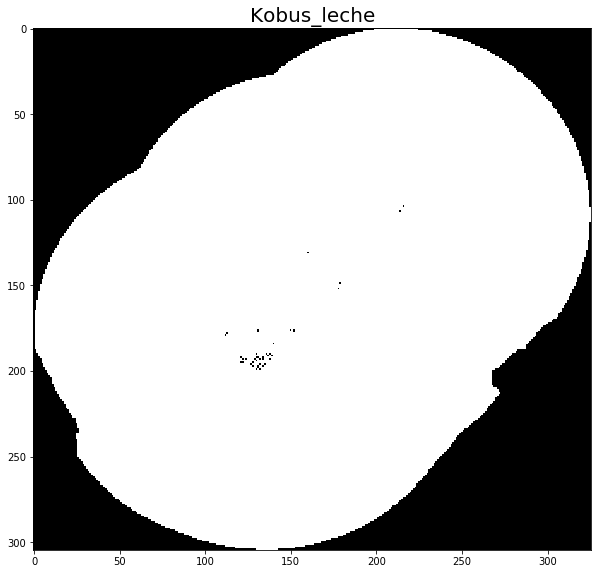

46 number of pseudo absences
92 lenght data with pseudo absences


Text(0.5, 1.0, 'Kobus_megaceros')

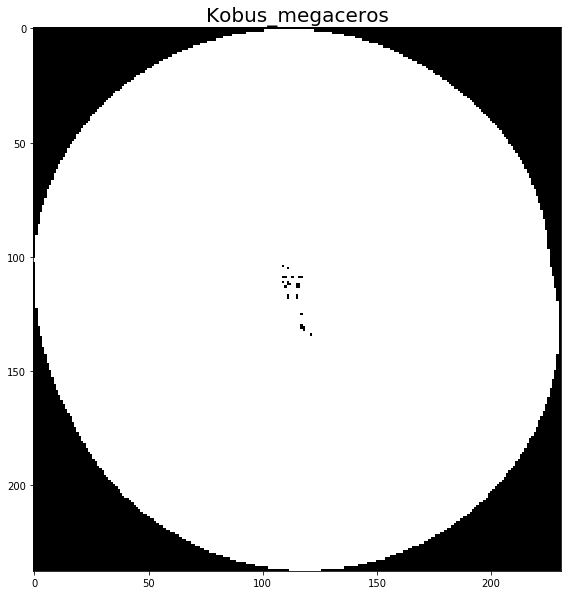

60 number of pseudo absences
120 lenght data with pseudo absences


Text(0.5, 1.0, 'Kobus_vardonii')

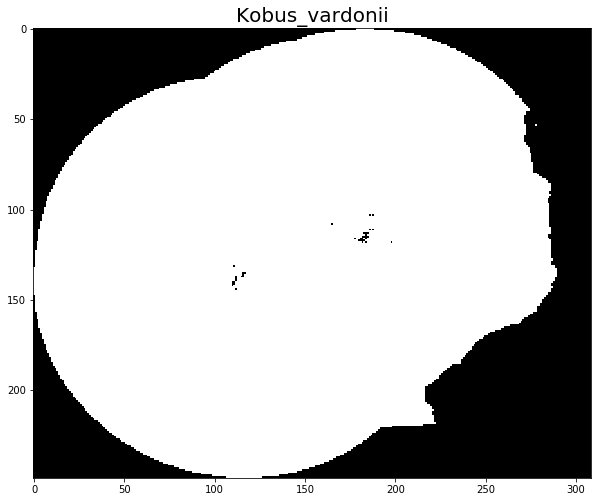

52 number of pseudo absences
104 lenght data with pseudo absences


Text(0.5, 1.0, 'Litocranius_walleri')

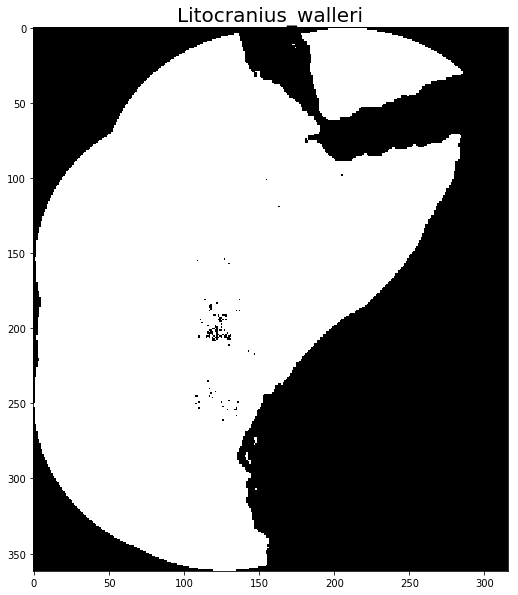

190 number of pseudo absences
380 lenght data with pseudo absences


Text(0.5, 1.0, 'Madoqua_guentheri')

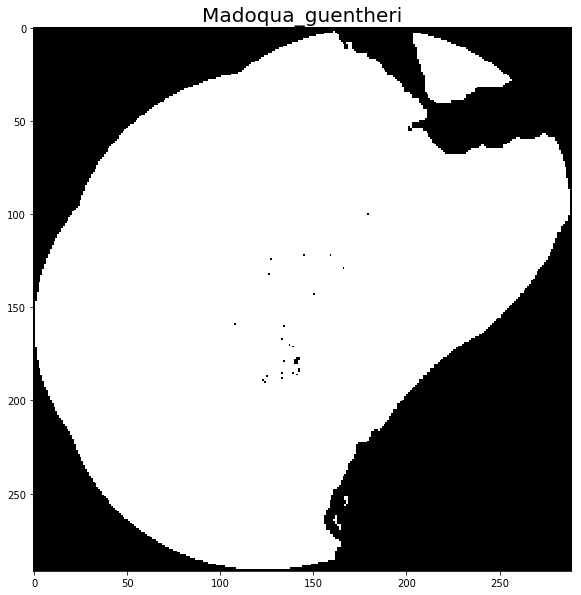

35 number of pseudo absences
70 lenght data with pseudo absences


Text(0.5, 1.0, 'Madoqua_kirkii')

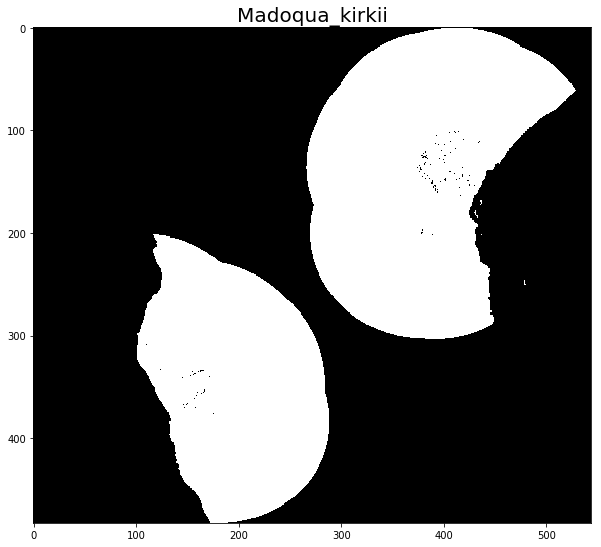

165 number of pseudo absences
330 lenght data with pseudo absences


Text(0.5, 1.0, 'Mazama_americana')

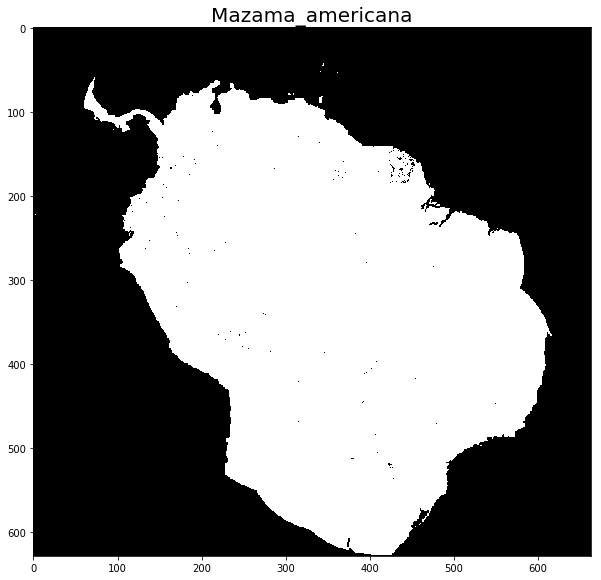

822 number of pseudo absences
1644 lenght data with pseudo absences


Text(0.5, 1.0, 'Mazama_gouazoubira')

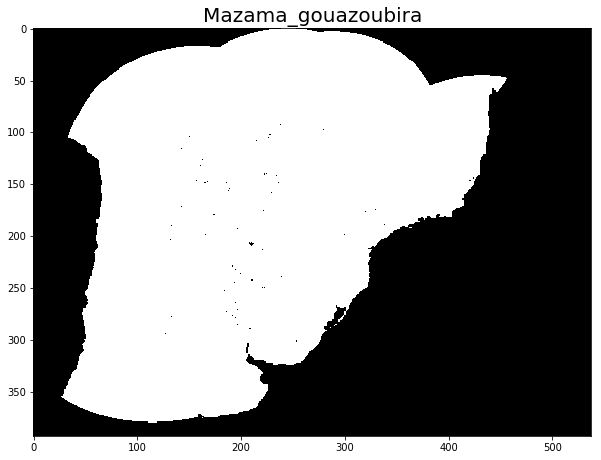

113 number of pseudo absences
226 lenght data with pseudo absences


Text(0.5, 1.0, 'Mazama_nana')

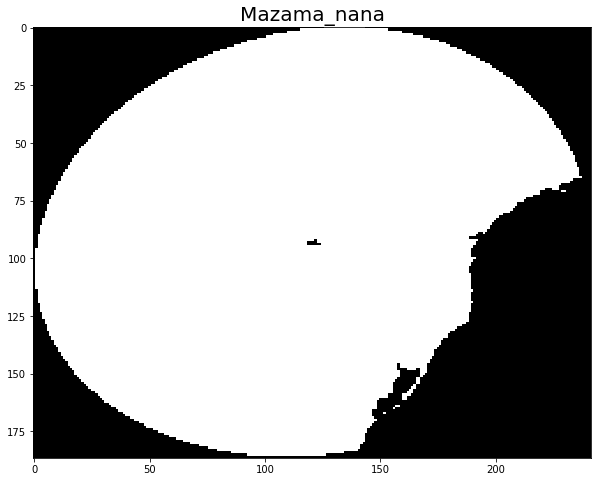

77 number of pseudo absences
154 lenght data with pseudo absences


Text(0.5, 1.0, 'Mazama_pandora')

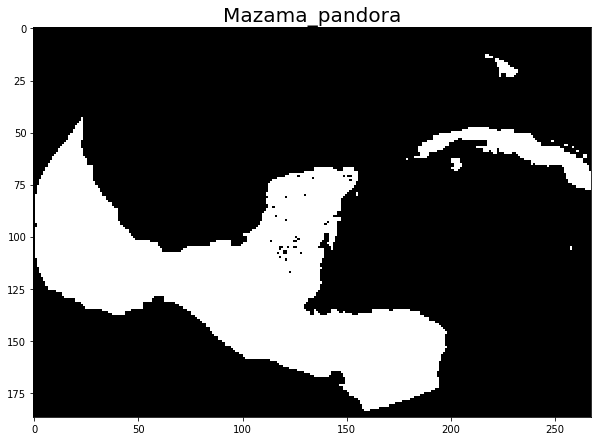

80 number of pseudo absences
160 lenght data with pseudo absences


Text(0.5, 1.0, 'Mazama_temama')

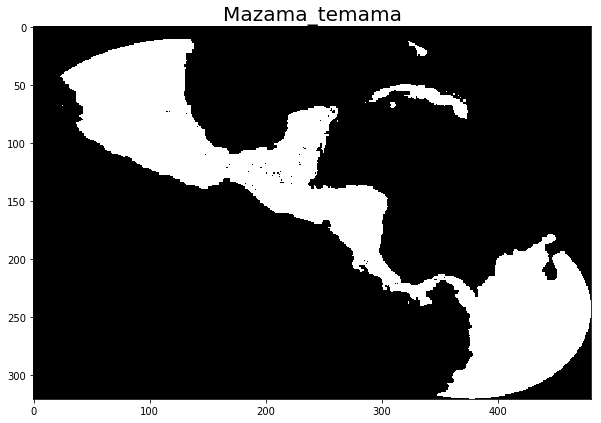

99 number of pseudo absences
198 lenght data with pseudo absences


Text(0.5, 1.0, 'Muntiacus_reevesi')

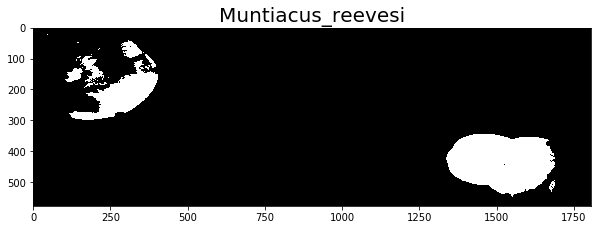

3180 number of pseudo absences
6360 lenght data with pseudo absences


Text(0.5, 1.0, 'Nanger_granti')

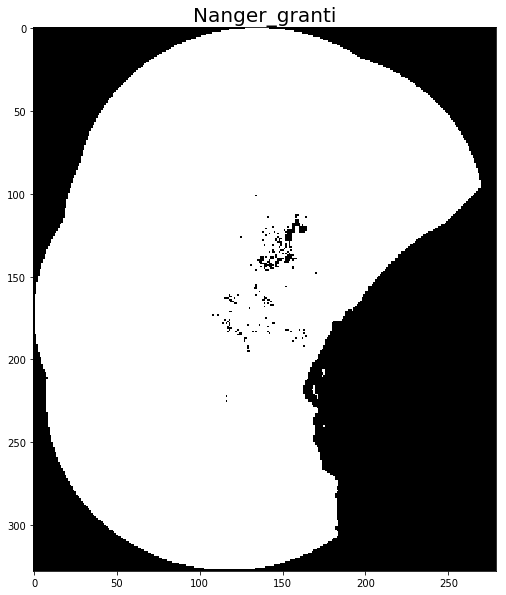

814 number of pseudo absences
1628 lenght data with pseudo absences


Text(0.5, 1.0, 'Nanger_soemmerringii')

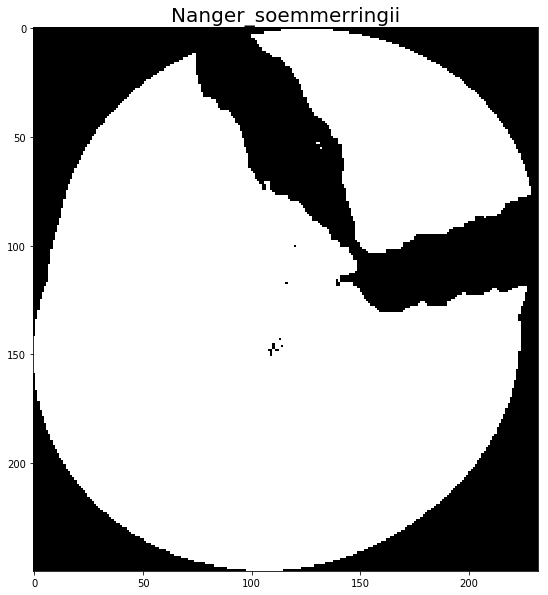

14 number of pseudo absences
28 lenght data with pseudo absences


Text(0.5, 1.0, 'Neotragus_batesi')

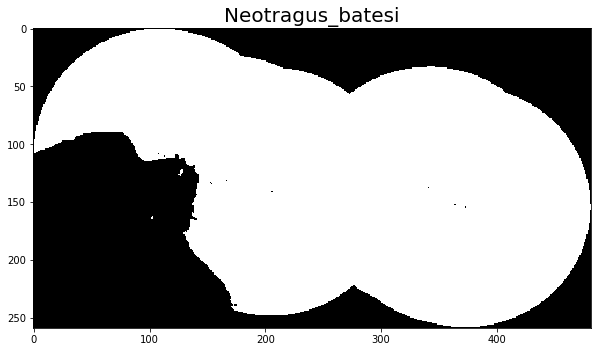

11 number of pseudo absences
22 lenght data with pseudo absences


Text(0.5, 1.0, 'Neotragus_pygmaeus')

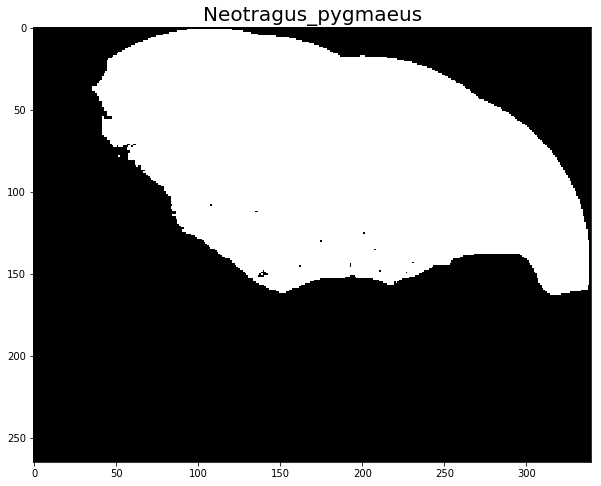

59 number of pseudo absences
118 lenght data with pseudo absences


Text(0.5, 1.0, 'Odocoileus_hemionus')

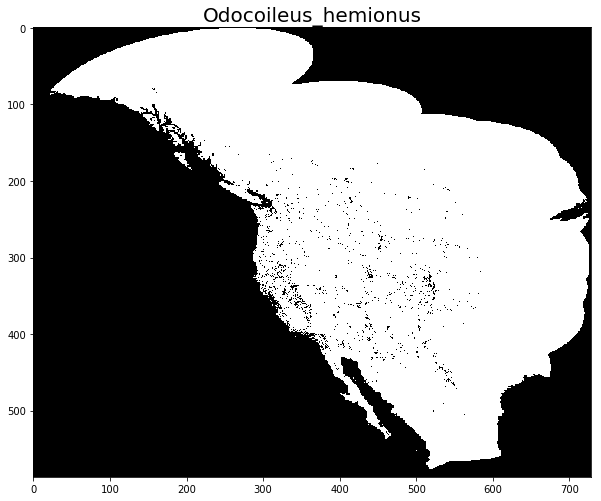

7270 number of pseudo absences
14540 lenght data with pseudo absences


Text(0.5, 1.0, 'Odocoileus_virginianus')

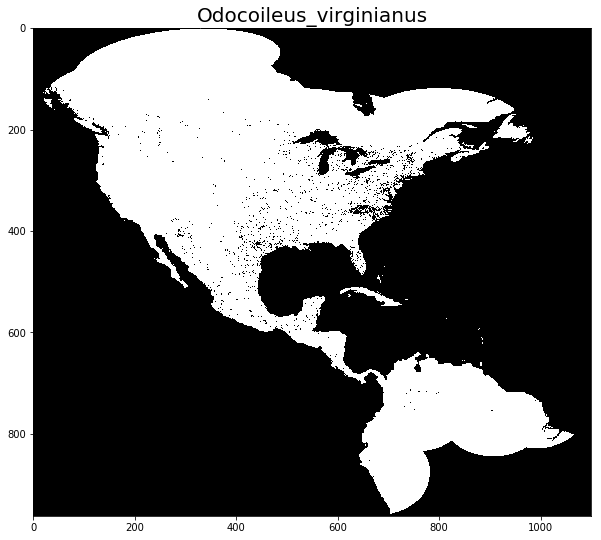

14922 number of pseudo absences
29844 lenght data with pseudo absences


Text(0.5, 1.0, 'Oreamnos_americanus')

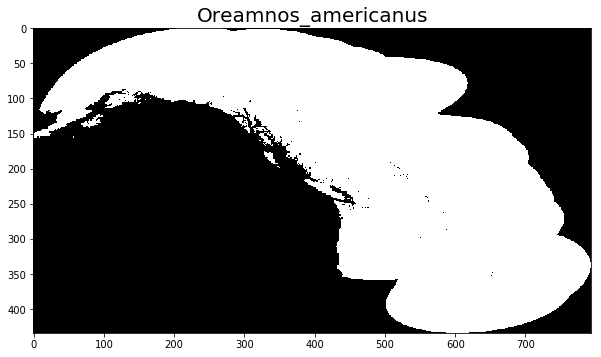

187 number of pseudo absences
374 lenght data with pseudo absences


Text(0.5, 1.0, 'Oreotragus_oreotragus')

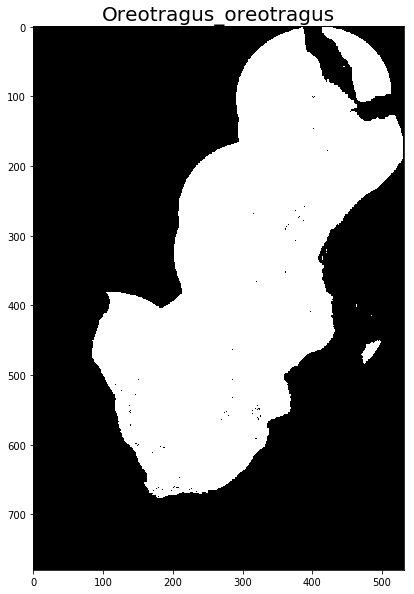

218 number of pseudo absences
436 lenght data with pseudo absences


Text(0.5, 1.0, 'Oryx_beisa')

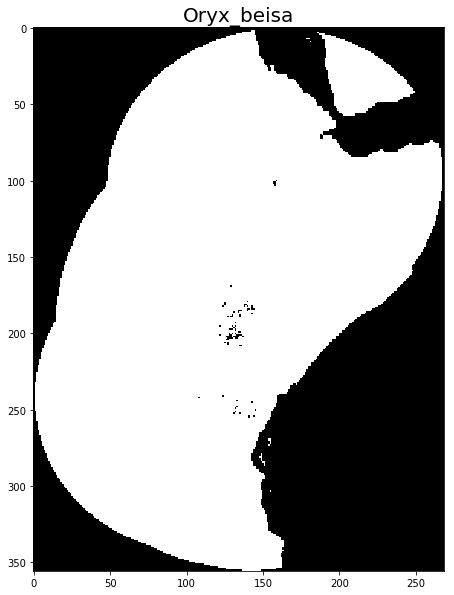

147 number of pseudo absences
294 lenght data with pseudo absences


Text(0.5, 1.0, 'Oryx_gazella')

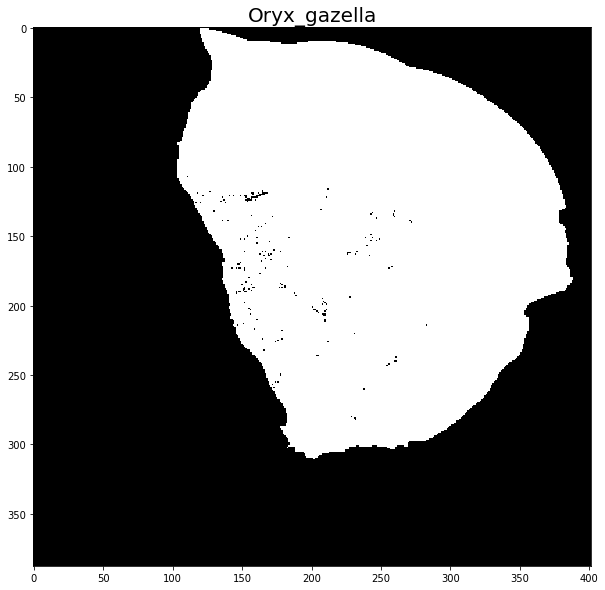

282 number of pseudo absences
564 lenght data with pseudo absences


Text(0.5, 1.0, 'Ourebia_ourebi')

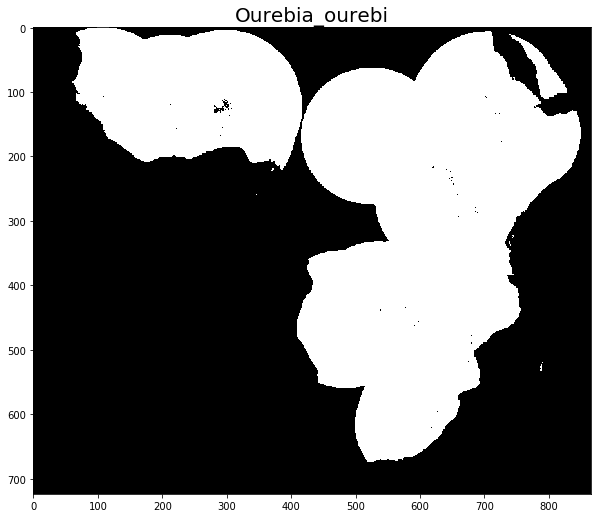

730 number of pseudo absences
1460 lenght data with pseudo absences


Text(0.5, 1.0, 'Ovibos_moschatus')

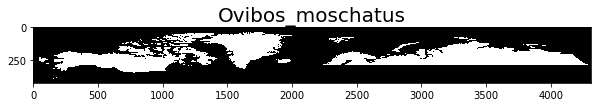

98 number of pseudo absences
196 lenght data with pseudo absences


Text(0.5, 1.0, 'Ovis_canadensis')

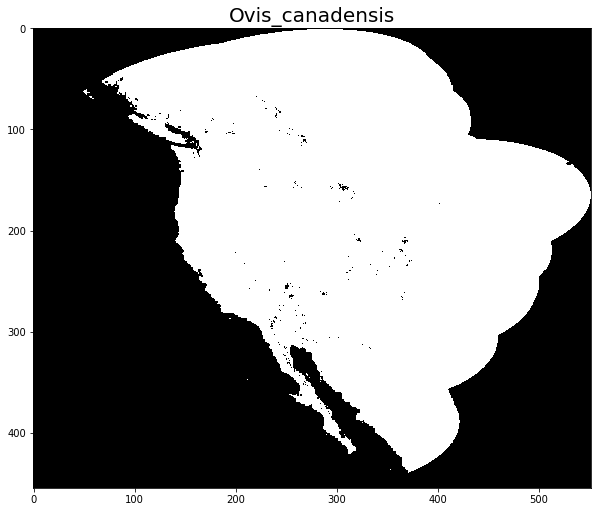

654 number of pseudo absences
1308 lenght data with pseudo absences


Text(0.5, 1.0, 'Ovis_dalli')

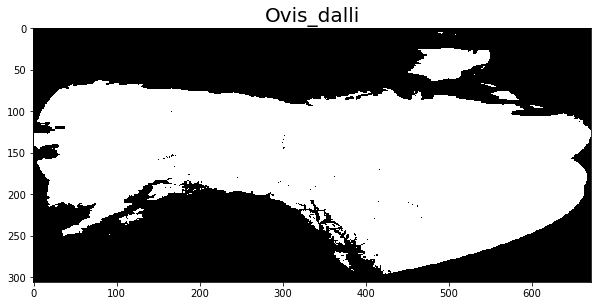

76 number of pseudo absences
152 lenght data with pseudo absences


Text(0.5, 1.0, 'Pecari_tajacu')

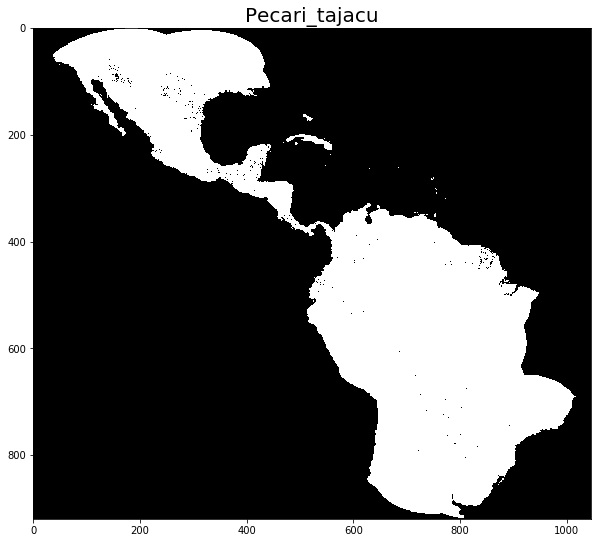

1715 number of pseudo absences
3430 lenght data with pseudo absences


Text(0.5, 1.0, 'Pelea_capreolus')

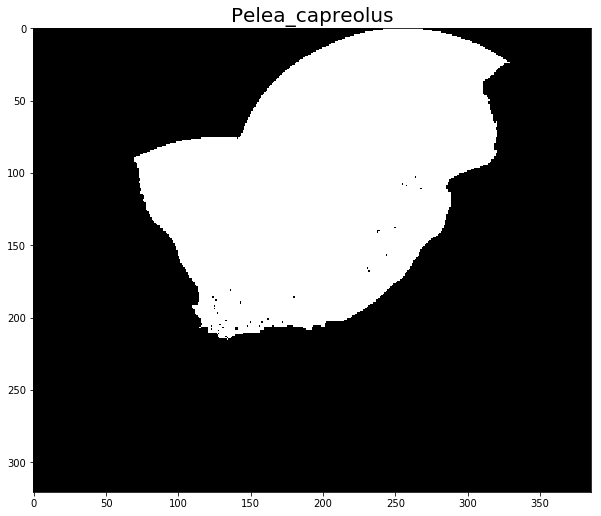

43 number of pseudo absences
86 lenght data with pseudo absences


Text(0.5, 1.0, 'Phacochoerus_aethiopicus')

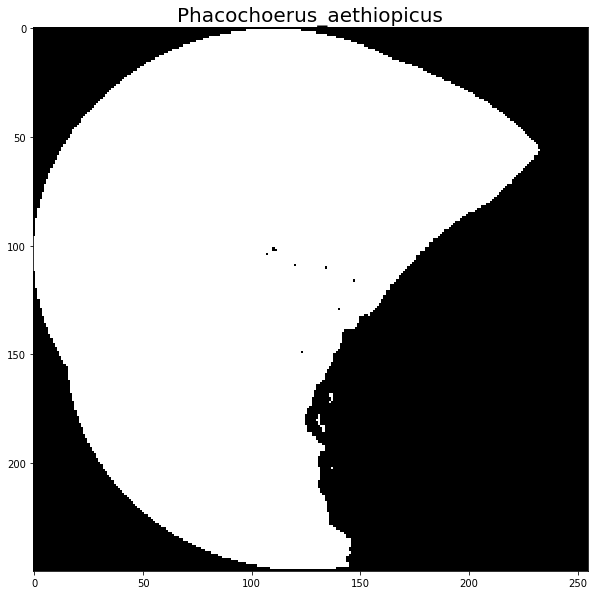

10 number of pseudo absences
20 lenght data with pseudo absences


Text(0.5, 1.0, 'Phacochoerus_africanus')

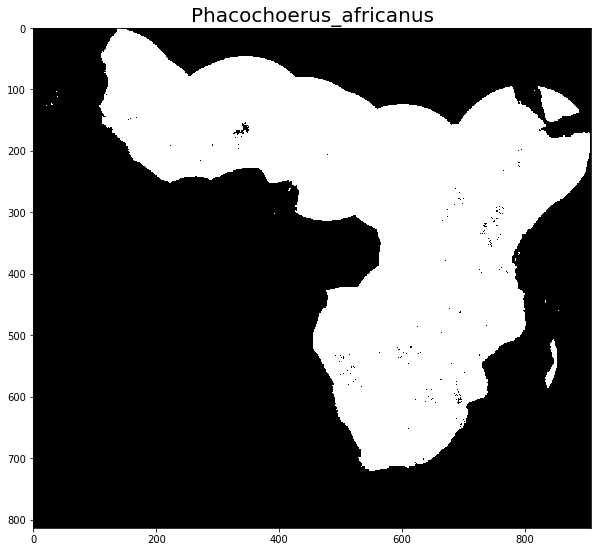

1960 number of pseudo absences
3920 lenght data with pseudo absences


Text(0.5, 1.0, 'Philantomba_maxwellii')

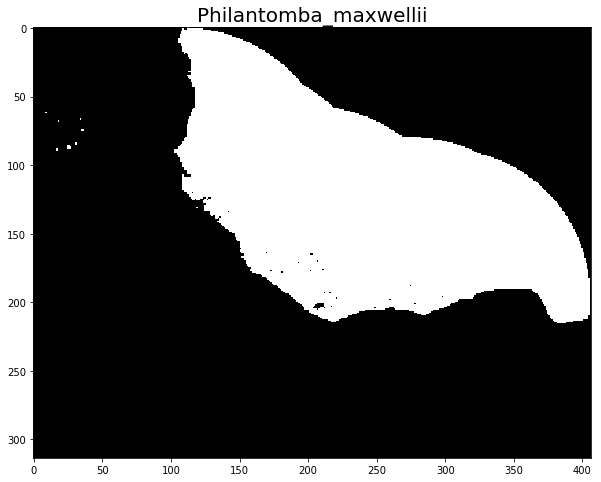

259 number of pseudo absences
518 lenght data with pseudo absences


Text(0.5, 1.0, 'Philantomba_monticola')

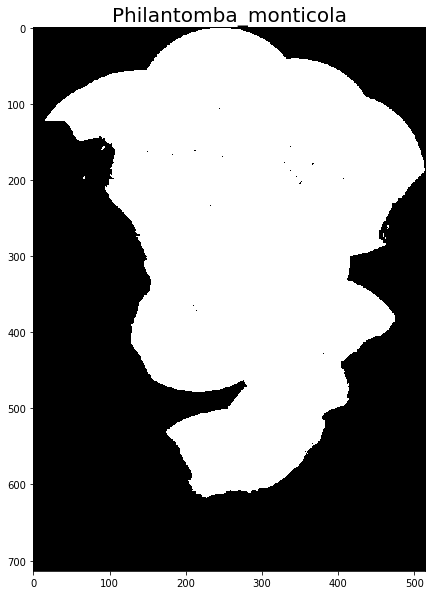

105 number of pseudo absences
210 lenght data with pseudo absences


Text(0.5, 1.0, 'Potamochoerus_larvatus')

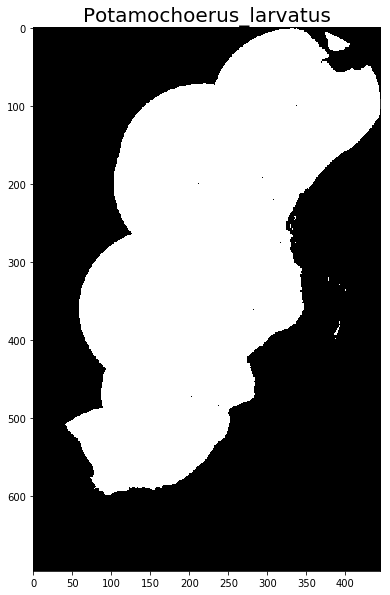

43 number of pseudo absences
86 lenght data with pseudo absences


Text(0.5, 1.0, 'Potamochoerus_porcus')

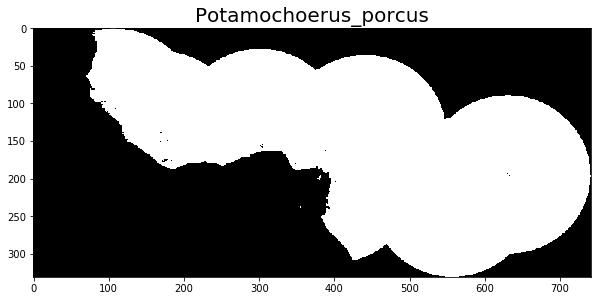

112 number of pseudo absences
224 lenght data with pseudo absences


Text(0.5, 1.0, 'Procapra_picticaudata')

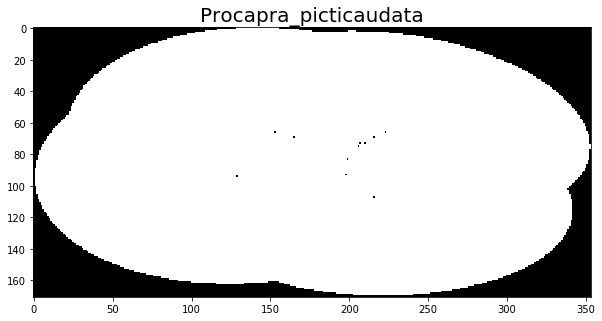

11 number of pseudo absences
22 lenght data with pseudo absences


Text(0.5, 1.0, 'Pseudois_nayaur')

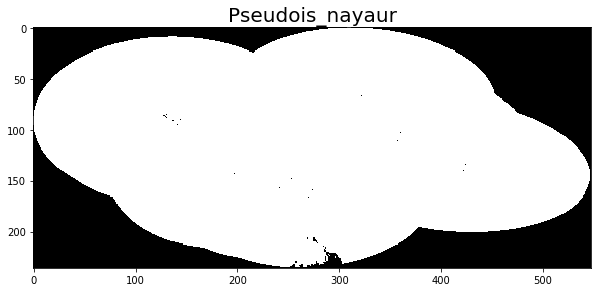

In [ ]:
for key in species_occ_dict:    
    #lon_lat presence points
    presence_data = species_occ_dict[key]
    presence_data["present/pseudo_absent"]=1
    spec = key
    long=presence_data["decimal_longitude"]
    lati=presence_data["decimal_latitude"]
    long=pd.Series.tolist(long)
    lati=pd.Series.tolist(lati)

    #read raster
    src=rasterio.open(file_dir+'/data/GIS/spec_stacked_raster_clip/%s_raster_clip.tif'%spec)
    array=src.read_masks(1)

    #set raster cell mask values of presence locations to 1
    for i in range(0,len(presence_data)):
        row,col=src.index(long[i],lati[i])
        array[row,col]=1
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(array,cmap="gray")
    ax.set_title("%s"%spec,
             fontsize=20)
    plt.show()
    (y_index, x_index) = np.nonzero(array > 1)

    #sample random locations from raster excluding sea and presence cells
    r = gdal.Open(file_dir+'/data/GIS/spec_stacked_raster_clip/%s_raster_clip.tif'%spec)
    (upper_left_x, x_size, x_rotation, upper_left_y, y_rotation, y_size) = r.GetGeoTransform()
    x_coords = x_index * x_size + upper_left_x + (x_size / 2) #add half the cell size
    y_coords = y_index * y_size + upper_left_y + (y_size / 2) #to centre the point


    lon_lat_array=np.stack((x_coords,y_coords)).T

    random_sample_size=int(len(presence_data))
    random_sample_lon_lats=lon_lat_array[np.random.choice(lon_lat_array.shape[0], random_sample_size, replace=False), :] #first did 10.000 now equal to n presences
    print(len(random_sample_lon_lats), "number of pseudo absences")

    #Add random points to dataset
    lon=[]
    lat=[]
    psa=[0]*random_sample_size
    taxon=["%s"%spec]*random_sample_size
    gbif=["no_id"]*random_sample_size

    for item in random_sample_lon_lats:
        longitude=item[0]
        latitude=item[1]
        lon.append(longitude)
        lat.append(latitude)

    ###Dataset including 10.000 pseudo-absence points for capriolus capriolus
    new_data=pd.DataFrame({"gbif_id": gbif,"taxon_name":taxon,"decimal_longitude": lon, "decimal_latitude":lat, "present/pseudo_absent": psa})
    data=pd.concat([presence_data,new_data],ignore_index=True)
    data=data[['taxon_name','gbif_id','decimal_longitude','decimal_latitude','present/pseudo_absent']]
    print(len(data),"lenght data with pseudo absences")
    data.to_csv(file_dir + "/data/spec_ppa/%s_ppa_dataframe.csv"%spec)


In [9]:
data=pd.read_csv(file_dir+'/data/spec_ppa/Capreolus_capreolus_ppa_dataframe.csv')
data

,Unnamed: 0,taxon_name,gbif_id,decimal_longitude,decimal_latitude,present/pseudo_absent
0,0,NaN,1238712545,10.186958,59.212556,NaN
1,1,NaN,1238712863,10.997104,63.441670,NaN
2,2,NaN,1238712973,11.752264,64.127008,NaN
3,3,NaN,1238713150,11.070541,63.449280,NaN
4,4,NaN,1238713204,11.263427,63.445108,NaN
5,5,NaN,1238713280,11.011073,63.215832,NaN
6,6,NaN,1238713329,7.310750,58.284707,NaN
7,7,NaN,1238713497,11.967527,63.362972,NaN
8,8,NaN,1238713518,8.600327,58.524391,NaN
9,9,NaN,1238713524,10.976775,63.412065,NaN


In [ ]:
 ###Dataset including all locations with data-values (to later predict presence-pseudoabsence on)
    src=rasterio.open(file_dir+'/data/GIS/spec_stacked_raster_clip/%s_raster_clip.tif'%spec)
    array=src.read_masks(1)

    r = gdal.Open(file_dir+'/data/GIS/spec_stacked_raster_clip/%s_raster_clip.tif'%spec)
    (y_index, x_index) = np.nonzero(array > 0)
    (upper_left_x, x_size, x_rotation, upper_left_y, y_rotation, y_size) = r.GetGeoTransform()
    x_coords = x_index * x_size + upper_left_x + (x_size / 2) #add half the cell size
    y_coords = y_index * y_size + upper_left_y + (y_size / 2) #to centre the point

    lon_lat_array=np.stack((x_coords,y_coords)).T

    lon=[]
    lat=[]

    for item in lon_lat_array:
        longitude=item[0]
        latitude=item[1]
        lon.append(longitude)
        lat.append(latitude)

    taxon=["%s"%spec]*len(lon)

    data_to_pred=pd.DataFrame({"taxon_name":taxon, "decimal_longitude":lon,"decimal_latitude":lat})
    print(len(data_to_pred), "number of points to predict")
    data_to_pred.to_csv(file_dir + "/data/capriolus_trial/%s_location_to_predict.csv")
